<h1><center><font size="6">Default of Taiwanese Credit Card Clients</font></center></h1>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Importing Packages</a>  
- <a href='#3'>Uploading Data</a>
- <a href='#4'>Creating Train, Validation, and Testing Sets</a>  
- <a href='#5'>Data Cleaning</a>  
- <a href='#5'>Exploratory Data Analysis</a>
- <a href='#6'>Feature Engineering</a>  
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>


# <a id:'1'>Introduction</a>

From the UCI dataset website: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

**Target variable:**
- default payment (Yes = 1, No = 0)

**Explanatory variables:**
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit
- X2: Gender (1 = Male; 2 = Female)
- X3: Education (1 = Graduate; 2 = University; 3 = High School; 4 = Other)
- X4: Marital status (1 = Married; 2 = Single; 3 = Other)
- X5: Age (year)
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September 2005) as follows: 
    - X6 = repayment status in September
    - ...
    - X11 = repayment status in April 
    - The measurement scale for the repayment status is: 
        - -1 = payments current
        - 1 = delayed payment for 1 month 
        - ...
        - 9 = delayed payment for 9 months and above
- X12-X17: Amount of Billed Statement (NT dollar)
    - X12 = amount of bill statement in September
    - ...
    - X17 = amount of bill statement in April
- X18-X23: Amount of previous payment (NT dollar) 
    - X18 = amount paid in August, 2005
    - X19 = amount paid in August, 2005
    - ...
    - X23 = amount paid in April, 2005


# <a id:'2'>Importing Packages</a>

In [1]:
# Importing Packages
import numpy as np 
import pandas as pd
import re
import json
import requests
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split

# <a id='2'>Uploading Data</a>

In [2]:
df = pd.read_excel("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/default of credit card clients.xls")
new_header = df.iloc[0]
df = df[1:] 
df.columns = new_header
df = df.rename(columns={"default payment next month": "default"}) 
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.dtypes

0
ID           object
LIMIT_BAL    object
SEX          object
EDUCATION    object
MARRIAGE     object
AGE          object
PAY_0        object
PAY_2        object
PAY_3        object
PAY_4        object
PAY_5        object
PAY_6        object
BILL_AMT1    object
BILL_AMT2    object
BILL_AMT3    object
BILL_AMT4    object
BILL_AMT5    object
BILL_AMT6    object
PAY_AMT1     object
PAY_AMT2     object
PAY_AMT3     object
PAY_AMT4     object
PAY_AMT5     object
PAY_AMT6     object
default      object
dtype: object

# <a id='4'>Creating Train, Validation, and Testing Sets</a>

In [4]:
X = df.drop(["default"], axis=1)
y = df["default"]
# split the full data 80:20 into training:validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)
# split training data 87.5:12.5 into training:testing sets
X_tr, X_tt, y_tr, y_tt = train_test_split(X_train, y_train, train_size=0.875, random_state=42)
train = pd.concat([X_tr, y_tr], axis=1)
val = pd.concat([X_val, y_val], axis=1)

In [5]:
# X_tt.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/testing.csv")
# y_tt.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/testing_labels.csv")
# train.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/training.csv", index=False)
# val.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/validate.csv", index=False)

# <a id='5'>Data Cleaning</a>

In [21]:
tr = pd.read_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/training.csv")
val = pd.read_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/validate.csv")
tr = tr.drop(["ID"], axis=1)
val = val.drop(["ID"], axis=1)
tr.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
default      int64
dtype: object

In [22]:
tr.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,50000,2,2,1,44,0,0,0,0,0,0,45578,41906,35703,22360,23659,27421,3016,5003,3000,3000,5000,924,0
1,160000,2,3,1,46,-1,-1,-1,0,-1,-1,24904,2338,4856,4127,3995,842,2343,4856,1000,3995,842,26313,0
2,100000,2,2,1,47,-1,-1,-1,-1,-1,-2,6666,6666,0,6270,-396,-396,6666,0,6270,0,0,0,1
3,170000,2,2,1,29,0,0,0,0,0,0,79091,62575,63317,63903,43505,43995,2235,2493,2585,1683,1901,2111,0
4,150000,2,1,2,33,-2,-2,-2,-2,-2,-2,24393,26847,32702,33459,27800,2261,27007,32715,33475,27808,2261,169465,0


In [23]:
tr.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,167214.937143,1.605190,1.854333,1.549476,35.538286,-0.015524,-0.130952,-0.165667,-0.216952,-0.261238,-0.284810,51115.879143,49164.750619,4.696772e+04,43174.979429,40376.466143,38976.187810,5732.100667,6.006080e+03,5279.434524,4927.353714,4822.283381,5156.729952,0.221714
std,129561.159854,0.488821,0.794086,0.523126,9.257936,1.127750,1.200066,1.194393,1.170611,1.136246,1.156573,73469.974615,71175.850265,6.960624e+04,64284.893891,61004.334726,59676.470266,17510.937498,2.508609e+04,18647.406220,16803.515819,15620.014696,17658.819827,0.415410
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3566.500000,3033.500000,2.743750e+03,2350.750000,1782.000000,1301.750000,1000.000000,8.360000e+02,390.000000,291.000000,243.000000,116.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22460.500000,21417.000000,2.007300e+04,19038.500000,18100.000000,17128.500000,2100.000000,2.007000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66759.750000,63291.250000,5.969425e+04,54345.500000,50289.250000,49413.000000,5007.000000,5.000000e+03,4500.000000,4001.000000,4034.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,417990.000000,527143.000000,1.000000


In [24]:
# Use requests and json modules to webscrape current exchange rate for TWD to USD
url = 'https://openexchangerates.org/api/latest.json?app_id=c51b1508fb4145259b1c2fade72a2c04'
response = requests.get(url)
data = response.json()
rate = data['rates']['TWD']

In [25]:
# change column names for easier reference
data = [tr, val]
for d in data:    
    d.rename(columns={"PAY_0": "behind1", 
                        "PAY_2": "behind2", 
                        "PAY_3": "behind3", 
                        "PAY_4": "behind4",
                        "PAY_5": "behind5", 
                        "PAY_6": "behind6", 
                        "BILL_AMT1": "billed1", 
                        "BILL_AMT2": "billed2", 
                        "BILL_AMT3": "billed3", 
                        "BILL_AMT4": "billed4", 
                        "BILL_AMT5": "billed5", 
                        "BILL_AMT6": "billed6", 
                        "PAY_AMT1": "paid1", 
                        "PAY_AMT2": "paid2", 
                        "PAY_AMT3": "paid3", 
                        "PAY_AMT4": "paid4", 
                        "PAY_AMT5": "paid5", 
                        "PAY_AMT6": "paid6",
                        "SEX": "gender",
                        "EDUCATION": "education",
                        "MARRIAGE": "marriage",
                        "AGE": "age",
                        "LIMIT_BAL": "limit"}, inplace=True)

In [26]:
# Change all TWDs to USDs
for d in data:
    d[['limit']] = d[['limit']]/rate
    d[['billed1', 'billed2', 'billed3', 'billed4', 'billed5', 'billed6']] = d[['billed1', 'billed2', 'billed3', 'billed4', 'billed5', 'billed6']].divide(rate, axis=1)
    d[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']] = d[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']].divide(rate, axis=1)

In [27]:
for d in data:
    d['limit'] = d['limit'].apply(lambda x: round(x, 2))
    d[['billed1', 'billed2', 'billed3', 'billed4', 'billed5', 'billed6']] = d[['billed1', 'billed2', 'billed3', 'billed4', 'billed5', 'billed6']].apply(lambda x: round(x, 2))
    d[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']] = d[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']].apply(lambda x: round(x, 2))

In [28]:
tr.describe()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,behind6,billed1,billed2,billed3,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6,default
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,5972.494578,1.605190,1.854333,1.549476,35.538286,-0.015524,-0.130952,-0.165667,-0.216952,-0.261238,-0.284810,1825.730096,1756.040714,1677.568418,1542.101212,1442.145400,1392.131017,204.735832,214.521755,188.567871,175.992434,172.239617,184.185160,0.221714
std,4627.598010,0.488821,0.794086,0.523126,9.257936,1.127750,1.200066,1.194393,1.170611,1.136246,1.156573,2624.161949,2542.221651,2486.158986,2296.094094,2178.920813,2131.492822,625.446471,896.011634,666.038294,600.179133,557.907481,630.728439,0.415410
min,357.170000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-5914.100000,-2492.260000,-5617.070000,-6071.970000,-2905.050000,-7466.770000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1785.870000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,127.382500,108.352500,97.997500,83.962500,63.650000,46.492500,35.720000,29.860000,13.930000,10.390000,8.680000,4.170000,0.000000
50%,5000.450000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,802.235000,764.960000,716.960000,680.005000,646.490000,611.785000,75.010000,71.680000,64.290000,53.580000,53.580000,53.580000,0.000000
75%,8572.190000,2.000000,2.000000,2.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2384.487500,2260.602500,2132.130000,1941.085000,1796.207500,1764.905000,178.840000,178.590000,160.730000,142.910000,144.085000,142.870000,0.000000
max,35717.470000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,34449.900000,35143.530000,59437.060000,31845.200000,33116.210000,34348.210000,31201.070000,60157.480000,32004.290000,22180.550000,14929.550000,18828.220000,1.000000


In [29]:
# put all zero values into category of 3 for marriage
# lump all the other and unknown education categories together:  0, 5, 6 values to category 4
for d in data:  
    d.replace({'marriage': {0:3}}, inplace=True)
    d.replace({'education': {5:4, 0:4, 6:4}}, inplace=True)

In [30]:
# -2 is the same as -1. but turn them all into 0's, since it makes more sense within context or meaning, i.e. client is zero months behind payment
datasets = ['behind1', 'behind2', 'behind3', 'behind4', 'behind5', 'behind6']
for data in datasets:
    tr.replace({data: {-2: 0, -1: 0}}, inplace=True)
    val.replace({data: {-2: 0, -1: 0}}, inplace=True)

In [18]:
# tr.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/train_cleaned.csv", index=False)
# val.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/validate_cleaned.csv", index=False)

# <a id='6'>Exploratory Data Analysis</a>

In [39]:
categorical = tr[['gender', 'marriage', 'education', 'behind1', 'behind2', 'behind3', 'behind4', 'behind5', 'behind6']]
continuous = tr[['limit', 'age', 'billed1', 'billed2', 'billed3', 'billed4', 'billed5', 'billed6', 'paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']]
cat_col = categorical.columns
cont_col = continuous.columns

In [77]:
# con_1 = pd.melt(tr, value_vars = cont_col)
# sns.set_theme(style="darkgrid", font='serif', context='talk')
# g = sns.FacetGrid(con_1, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
# g = g.map(sns.distplot, 'value', color='r')
# g.set_xticklabels(rotation=45)
# plt.savefig("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/images/distplot.png")

<img src="../images/distplot.png">

In [76]:
# Use bar graphs of the distribution of data for categorical variables
# cat_1 = pd.melt(tr, value_vars=cat_col)
# sns.set_theme(style="darkgrid", font='serif', context='talk')
# g = sns.FacetGrid(cat_1, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
# g = g.map(sns.countplot, 'value', color='dodgerblue')
# g.set_xticklabels()
# plt.savefig("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/images/countplot.png")

<img src="../images/countplot.png">

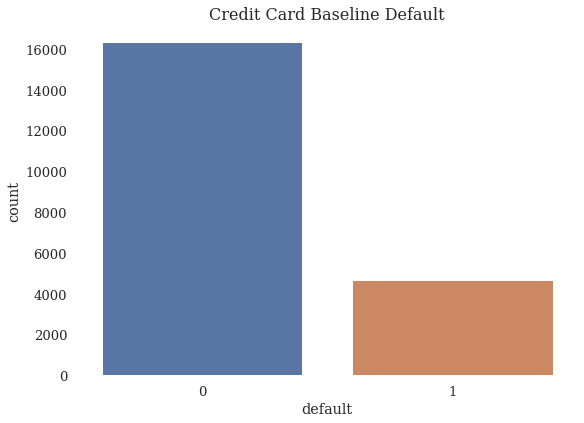

In [104]:
yes = tr.default.sum()
no = len(tr)-yes
perc_y = round(yes/len(tr)*100, 1)
perc_n = round(no/len(tr)*100, 1)

plt.figure(figsize=(8,6))
sns.set_context('notebook', font_scale=1.2)
sns.countplot('default', data=tr)
plt.title('Credit Card Baseline Default', size=16)
plt.box(False);
plt.savefig("../images/baseline.png")

In [26]:
print(yes)
print(no)
print(perc_y)
print(perc_n)

4656
16344
22.2
77.8


In [94]:
# subset = tr[['gender', 'education', 'marriage', 'behind1', 'behind2', 'behind3', 'behind4', 'behind5', 'behind6', 'default']]
# f, axes = plt.subplots(3, 3, figsize=(15, 12), facecolor='white')
# sns.set_theme(style="darkgrid", font='serif', context='paper')
# f.suptitle('Frequency of Categorical Variables', size=16)
# ax1 = sns.countplot(x="gender", hue="default", data=subset, ax=axes[0,0])
# ax2 = sns.countplot(x="education", hue="default", data=subset, ax=axes[0,1])
# ax3 = sns.countplot(x="marriage", hue="default", data=subset, ax=axes[0,2])
# ax4 = sns.countplot(x="behind1", hue="default", data=subset, ax=axes[1,0])
# ax5 = sns.countplot(x="behind2", hue="default", data=subset, ax=axes[1,1])
# ax6 = sns.countplot(x="behind3", hue="default", data=subset, ax=axes[1,2])
# ax7 = sns.countplot(x="behind4", hue="default", data=subset, ax=axes[2,0])
# ax8 = sns.countplot(x="behind5", hue="default", data=subset, ax=axes[2,1])
# ax9 = sns.countplot(x="behind6", hue="default", data=subset, ax=axes[2,2])
# plt.savefig("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/images/default_freq_by_cat.png")

<img src="../images/default_freq_by_cat.png">

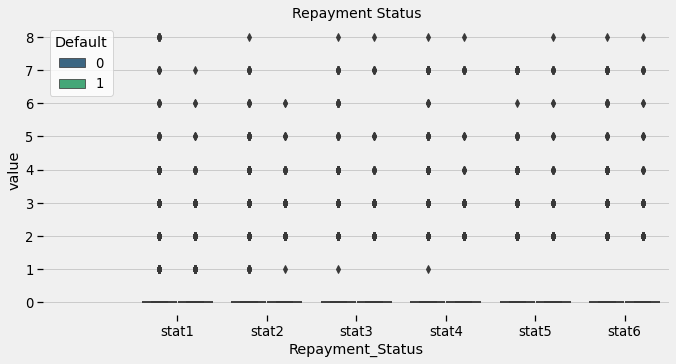

In [29]:
status = tr[['stat1', 'stat2', 'stat3', 'stat4', 'stat5', 'stat6']]
status = pd.concat([y, status],axis=1)
status = pd.melt(status,id_vars="default",
                    var_name="Repayment_Status",
                    value_name='value')

plt.figure(figsize=(10,5))
sns.set_context('notebook', font_scale=1.2)
sns.boxplot(y="value", x="Repayment_Status", hue="default", data=status, palette='viridis')
plt.legend(loc='best', title= 'Default', facecolor='white')
plt.xlim([-1.5,5.5])
plt.title('Repayment Status', size=14)
plt.box(False)

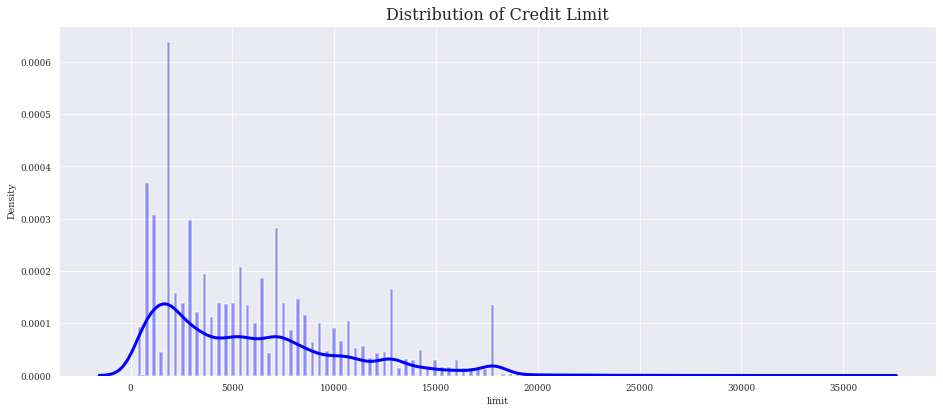

<Figure size 432x288 with 0 Axes>

In [103]:
plt.figure(figsize = (14,6))
plt.title('Distribution of Credit Limit', size=16)
sns.set_theme(style="darkgrid", font='serif', context='poster')
g = sns.distplot(tr['limit'], kde=True, bins=200, color="blue")
plt.show()
plt.savefig("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/images/credit_limit.png")

In [92]:
class_0 = tr.loc[tr['default'] == 0]["limit"]
class_1 = tr.loc[tr['default'] == 1]["limit"]
plt.figure(figsize = (14,6))
plt.title('Credit Limit by Default', size=16)
sns.set_theme(style="darkgrid", font='serif', context='poster')
sns.distplot(class_1, kde=True, bins=200, color="dodgerblue", label="No")
sns.distplot(class_0, kde=True, bins=200, color="red", label="Yes")
plt.legend(title = 'default', loc='upper right', facecolor='white')
plt.show()
plt.savefig("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/images/credit_limit_by_default.png")

In [37]:
sex = tr.groupby(['gender', 'default']).size().unstack(1)
sex

default,0,1
gender,,
1,6272,2019
2,10072,2637


<AxesSubplot:xlabel='gender'>

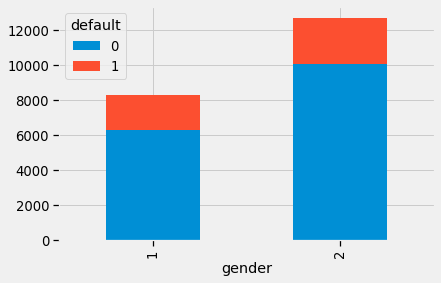

In [38]:
sex.plot(kind="bar", stacked=True)

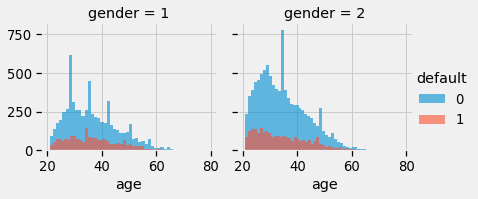

In [85]:
g = sns.FacetGrid(tr, col='gender', hue='default')
g.map(plt.hist, 'age', alpha=0.6, bins=50)
g.add_legend()

In [93]:
g = sns.FacetGrid(tr, col='default', row="marriage", hue='gender')
g.map_data(plt.hist, 'age', alpha=0.3, bins=50)
g.add_legend()

SyntaxError: invalid syntax (<ipython-input-93-7f8ac1ca2839>, line 3)

In [98]:
# g = sns.pairplot(tr[['gender', 'education', 'marriage', 'limit', 'age', 'default']], 
#              hue="default", 
#              diag_kind="kde",
#              size=4);
# g.savefig("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/images/pairplot1.png")

<img src="../images/pairplot1.png">

In [106]:
# g = sns.pairplot(tr[['behind1', 'behind2', 'behind3', 'behind4', 'behind5', 'behind6', 'default']], 
#              hue="default", 
#              diag_kind="kde",
#              size=4)
# g.savefig("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/images/pairplot2.png")

<img src="../images/pairplot2.png">

In [ ]:
sns.pairplot(tr[['billed1', 'billed2', 'billed3', 'billed4', 'billed5', 'billed6', 'default']], 
             hue="default", 
             diag_kind="kde",
             size=4)
g.savefig("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/images/pairplot3.png")

In [ ]:
sns.pairplot(tr[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6', 'default']], 
             hue="default", 
             diag_kind="kde",
             size=4);

# <a id='7'>Feature Engineering</a>

In [77]:
data = [tr, val]
for d in data:
    d['age_bin'] = 0
    d.loc[((d['age'] > 20) & (d['age'] < 30)) , 'age_bin'] = 1
    d.loc[((d['age'] >= 30) & (d['age'] < 40)) , 'age_bin'] = 2
    d.loc[((d['age'] >= 40) & (d['age'] < 50)) , 'age_bin'] = 3
    d.loc[((d['age'] >= 50) & (d['age'] < 60)) , 'age_bin'] = 4 
    d.loc[((d['age'] >= 60) & (d['age'] < 70)) , 'age_bin'] = 5
    d.loc[((d['age'] >= 70) & (d['age'] < 81)) , 'age_bin'] = 6


In [79]:
# fraction of estimated available balance based on what is billed per month and credit limit
for d in data:
    d['avail6'] = (d.limit - d.bill6) / d.limit
    d['avail5'] = (d.limit - d.bill5) / d.limit
    d['avail4'] = (d.limit - d.bill4) / d.limit
    d['avail3'] = (d.limit - d.bill3) / d.limit
    d['avail2'] = (d.limit - d.bill2) / d.limit
    d['avail1'] = (d.limit - d.bill1) / d.limit

In [81]:
# create feature of 
for d in data:
    d['avg_av'] = (d.avail1 + d.avail2 + d.avail3 + d.avail4 + d.avail5 + d.avail6) / 6

In [86]:
# the ratio of amount paid and amount billed
for d in data:
    d['pperb1'] = d.paid1 / d.bill2
    d['pperb2'] = d.paid2 / d.bill3
    d['pperb3'] = d.paid3 / d.bill4
    d['pperb4'] = d.paid4 / d.bill5
    d['pperb5'] = d.paid5 / d.bill6

In [91]:
datasets = ['pperb1', 'pperb2', 'pperb3', 'pperb4', 'pperb5']
for data in datasets:
    tr.replace({data: {np.inf: 0, np.nan: 0}}, inplace=True)
    val.replace({data: {np.inf: 0, np.nan: 0}}, inplace=True)

In [94]:
tr.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/train_feature.csv", index=False)
val.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/validate_feature.csv", index=False)